# Programming Exercise 2: Logistic Regression with regularization

Regularized Logistic regression is a classification algorithm 

In [223]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
 

Number of samples 118
Number of parameters:  2
y shape (118,)


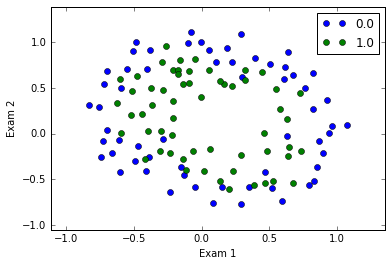

In [249]:
data = np.loadtxt('ex2data2.txt', delimiter=',')

X = data[:,0:2]
y = data[:,2]  # differs from y = data[:, 2:3]
m,n = X.shape
print('Number of samples', m)
print('Number of parameters: ', n)
print('y shape', y.shape)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
groups = df.groupby(y)
plt.margins(0.15)
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)

plt.xlabel('Exam 1')
plt.ylabel('Exam 2')
plt.legend()
plt.show()


## try solution directly from scikit learn

In [250]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#lr = LogisticRegression() # default solver to 'liblinear"

# lbfgs seems to be Same as mine
lr = LogisticRegression(solver='lbfgs', C=0.99)  # C = 1/lambda (default = 1, if lower, regularization is stronger)
#lr = LogisticRegression(solver='sag', max_iter = 1000000000)  # ???
#lr = LogisticRegression(solver='newton-cg', max_iter = 1000000000)  # seems quite the same as lbfgs

lr.fit(X_train,y_train)
lr.get_params()

print('Coeff = {}, intercept = {}'.format(lr.coef_, lr.intercept_ ))

print('Score on training set : ', lr.score(X_train,y_train))
print('Score on test set : ', lr.score(X_test,y_test))


X_small_test = [
    [0,0],
    [-0.25,0.25],
    [0.2,0.5],
    [1,-1],
    [1,1],
    [-0.25, 1.5],  # expected as human : 1 1 1 0 0 0  
    [0,1],
    [0,-1]]
print('Predict on small test : ', lr.predict(X_small_test))


Coeff = [[-0.23983265  0.10201563]], intercept = [ 0.09041361]
Score on training set :  0.553191489362
Score on test set :  0.5
Predict on small test :  [ 1.  1.  1.  0.  0.  1.  1.  0.]


Explanation for the equation :
$z=w_{0} + w_{1}x_{1} + w_{2}x_{2}$

Here, $x{_2}$ is on y axis, so we can define the equation as follows:
$x_{2} = \frac{w_{0}}{w_{2}} - \frac{w_{1}}{w_{2}}x_{1}$

Obivously, this is not enough, simply because trying to define a linear boundary is not adapted to this problem

Predict on small test :  [ 1.  1.  1.  0.  0.  1.  0.]
[ 0.09041361 -0.23983265  0.10201563]


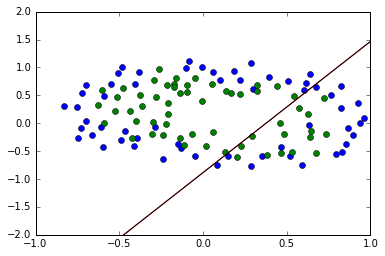

In [251]:
def plotDecisionBoundary(theta, X):
    # draw the line according to theta parameters
    plot_x = [min(X[:,1])-1, max(X[:,1]+1)]
    #print('plot_x:',plot_x)

    plot_y = (-1/theta[2]) * (np.multiply(theta[1],plot_x) + theta[0])
    #print('plot_y:',plot_y)

    plt.plot(plot_x, plot_y)

    #plt.show()
    
def plotDecisionBoundary2(lr):
    w = lr.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-1, 1)
    yy = a * xx - (lr.intercept_[0]) / w[1]
    plt.plot(xx, yy, 'k-')
    
X_check = [
    [0,0],
    [-1,1],
    [-1,-1],
    [1,1],
    [1,-1],
    [0,1],
    [0,-1]]
print('Predict on small test : ', lr.predict(X_check))

test = np.append(lr.intercept_, lr.coef_)
print(test)
plt.xlim(-1,1)
plt.ylim(-2,2)
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)
    

plotDecisionBoundary(test, X_train)
plotDecisionBoundary2(lr)
plt.show()

# Polynomial features
To have a non-linear boundary, we need polynomials. For instance, 6 power :
x1, x2, x1x2, x1^2*x2, x2^2*x1, x1^3 etc 

In [252]:
# Take a 2 parameters (3 with the ones) and return a n parameters according to polynomials parameters 
def generatePolynomials(order, X):
    #print('X:', X)
    XP = np.array([]).reshape(len(X), 0) #np.empty((len(X),1), dtype=float)
    #print('XP :  ', XP)
    for i in range(order+1):
        for j in range(i+1):
            #print('x1^{} * x2^{}'.format(j, i-j))
            temp = np.power(X[:,0:1], j)
            temp = np.power(X[:,1:2], i-j)
            XP = np.hstack((XP, np.power(X[:,0:1], j) * np.power(X[:,1:2], i-j)))
    return XP

(94, 28)
Coeff = [[  6.83160337e-04   6.91131077e+00   4.30349368e+00  -1.04332905e+01
   -5.93224779e+00  -4.98157302e+00  -5.14253189e+00   1.76879638e+00
   -7.41938444e-01   8.16088807e-01  -4.78713708e+00  -2.69849268e+00
   -3.49585341e+00   3.84473904e-01  -6.03326337e+00   2.52825235e+00
   -4.07045340e+00  -4.08508318e+00   3.00994422e+00  -4.02499696e-01
   -3.25517354e+00   2.83712079e+00  -4.36705540e+00  -4.40235645e+00
    2.28148471e+00  -3.49724742e-01  -7.46326264e-01  -7.54579313e+00]], intercept = [ 5.30598676]
Score on training set :  0.893617021277
Score on test set :  0.708333333333


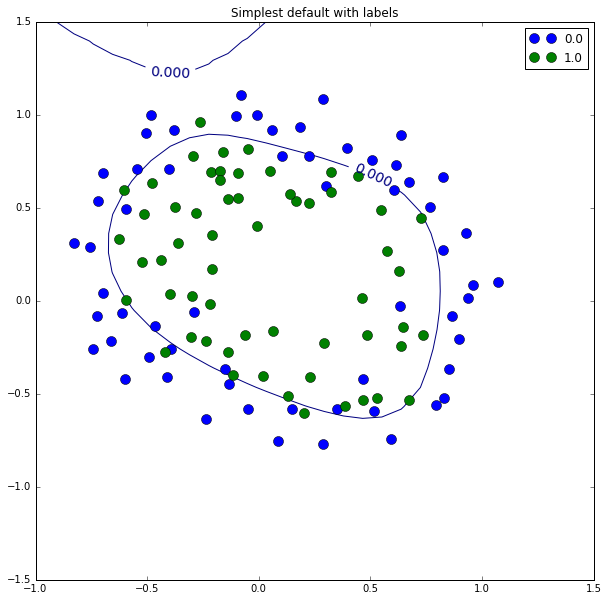

In [271]:
import functools

polynomial_order = 6
Lambda = 0.01

XP_train = generatePolynomials(polynomial_order, X_train)
XP_test = generatePolynomials(polynomial_order, X_test)

#print(XP_train)
print(XP_train.shape)

lr = LogisticRegression(solver='lbfgs', C=1/Lambda)  # C = 1/lambda (default = 1, if lower, regularization is stronger)

lr.fit(XP_train,y_train)
lr.get_params()

print('Coeff = {}, intercept = {}'.format(lr.coef_, lr.intercept_ ))

print('Score on training set : ', lr.score(XP_train,y_train))
print('Score on test set : ', lr.score(XP_test,y_test))

def plotDecisionBoundaryPoly(lr):
    def myexpit(n):
        #res = expit(n)
        #if res < 0.5:
        #    res = res/4
        #return res
        if n < 0: return 0.05
        else: return 0.35
    
    from scipy.special import expit

    u = np.linspace(-1, 1.5, 30)
    v = np.linspace(-1.5, 1.5, 30)
    
    z = np.zeros((len(u), len(v)))
    
    # for each tuple, evaluate z (after generating polynomials)
    for i in range (len(u)):
        for j in range (len(v)):
            x = np.array([u[i], v[j]]).reshape(1,2)
            
            #print('u,v = ',x)
            
            temp = generatePolynomials(polynomial_order, x)
            #print('poly uv = ', temp)
            zt = np.dot(temp,lr.coef_.transpose()) + lr.intercept_
            #print('z', zt)
            z[i,j] = zt
            #z = np.array(list(map(lambda z, x, y : myexpit(z[x,y]), z, range(len(u)), range(len(v)))))
            
    cs = plt.contour(u, v, z.transpose(), [0])
    plt.clabel(cs, inline=5, fontsize=14, cmap=plt.cm.RdGy)
    plt.title('Simplest default with labels')
    
    #for i in range(len(u)):
    #    for j in range(len(v)):
    #        plt.scatter(u[i], v[j], marker='o', s=100, alpha = myexpit(z[i,j]))
#
plt.figure(figsize=(10,10))
plotDecisionBoundaryPoly(lr)  
plt.xlim(-1,1.5)
plt.ylim(-1.5,1.5)
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name)
plt.legend()
plt.show()

In [103]:
x = np.array([ -0.5, 1]).reshape(1,2)
temp = generatePolynomials(6, x)
zt = np.dot(temp,lr.coef_.transpose()) + lr.intercept_
print(zt)
x = np.array([ 0, 0.5]).reshape(1,2)
temp = generatePolynomials(6, x)
zt = np.dot(temp,lr.coef_.transpose()) + lr.intercept_
print(zt)
x = np.array([ 0, 0.75]).reshape(1,2)
temp = generatePolynomials(6, x)
zt = np.dot(temp,lr.coef_.transpose()) + lr.intercept_
print(zt)


[[-2.06155594]]
[[ 1.31135809]]
[[ 0.53998498]]


[[-3.    -2.975 -2.95  ...,  2.925  2.95   2.975]
 [-3.    -2.975 -2.95  ...,  2.925  2.95   2.975]
 [-3.    -2.975 -2.95  ...,  2.925  2.95   2.975]
 ..., 
 [-3.    -2.975 -2.95  ...,  2.925  2.95   2.975]
 [-3.    -2.975 -2.95  ...,  2.925  2.95   2.975]
 [-3.    -2.975 -2.95  ...,  2.925  2.95   2.975]]
[[-2.    -2.    -2.    ..., -2.    -2.    -2.   ]
 [-1.975 -1.975 -1.975 ..., -1.975 -1.975 -1.975]
 [-1.95  -1.95  -1.95  ..., -1.95  -1.95  -1.95 ]
 ..., 
 [ 1.925  1.925  1.925 ...,  1.925  1.925  1.925]
 [ 1.95   1.95   1.95  ...,  1.95   1.95   1.95 ]
 [ 1.975  1.975  1.975 ...,  1.975  1.975  1.975]]


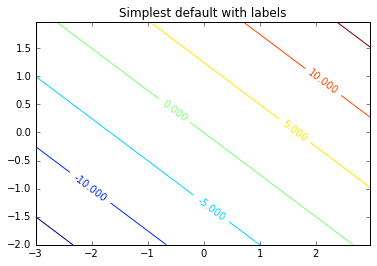

In [154]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
print(X)
print(Y)

plt.figure()
CS = plt.contour(X, Y, X*np.random.random_integers(5)+Y*np.random.random_integers(5))
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Simplest default with labels')